In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.tsatools import lagmat

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

data = pd.read_csv("SP500_constitutes_modified.csv")
data.Date = data.Date.apply(lambda x: pd.to_datetime(x))

ticker1 = "NDAQ-US"
ticker2 = "ICE-US"
ticker3 = "CME-US"
data = data.sort_values("Date").reset_index().drop("index", axis=1)
data = data[["Date", ticker1, ticker2, ticker3]]
#data["spread"] = data[ticker1] - data[ticker2]

#data = data[["Date", "spread"]]
data.index = data.Date

In [2]:
ticker = ticker3

In [3]:
stock1 = data[[ticker]].rename(columns={ticker: "price"})

In [4]:
def get_stock_ret(data):
    res = data.copy()
    res["ret"] = data.diff(1)
    res["ret_direction"] = data.diff(1).diff(1)
    return res

def diff_creation(data):
    df = data.copy()
    df["delta_ret"] = np.nan
    #df.loc[1:, "diff"] = (df.iloc[1:, 1].as_matrix() - df.iloc[:len(df)-1, 1].as_matrix())
    df.loc[1:, "delta_ret"] = df.ret.diff(1)
    return df

def lag_func(data, lag):
    lag = lag
    X = lagmat(data["delta_ret"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def train_test(data_lag, lag):
    xc = ["lag%d" % i for i in range(1,lag+1)]
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = (data_lag[(lag+1):]["delta_ret"] >= 0).apply(lambda x: int(x))
    date = data_lag["Date"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    date_train, date_test = date[:isplit], date[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt, date_train, date_test

In [5]:
temp = get_stock_ret(stock1)
temp = diff_creation(temp)
temp.ret_direction = (temp.ret_direction > 0).apply(lambda x: int(x))

In [6]:
temp = lag_func(temp, 7).reset_index()
temp.dropna(inplace=True)

In [7]:
x_train, y_train, x_test, y_test, xt, yt, date_train, date_test = train_test(temp, 7)

### Random Forest Classifier

In [8]:
param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4]}
rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)

#rf = RandomForestClassifier(n_estimators=200, max_depth=2)
rf.fit(x_train, y_train)
print(rf.best_estimator_)
rf = rf.best_estimator_
print("score on train:", rf.score(x_train, y_train))
print("score on test:", rf.score(x_test, y_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
score on train: 0.7621776504297995
score on test: 0.6133333333333333


/Users/clarence/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


accuracy score:  0.6133333333333333
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        73
           1       0.65      0.53      0.59        77

    accuracy                           0.61       150
   macro avg       0.62      0.62      0.61       150
weighted avg       0.62      0.61      0.61       150



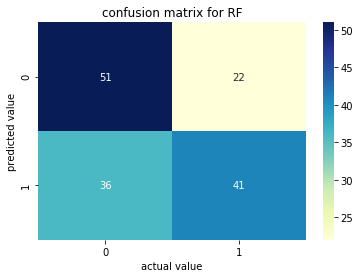

<Figure size 432x288 with 0 Axes>

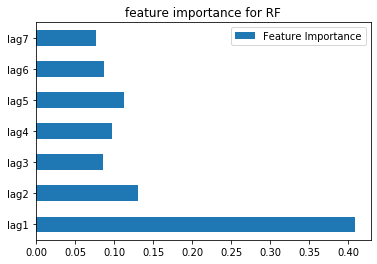

In [9]:
model = rf
y_pred = model.predict(x_test)

print("accuracy score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="YlGnBu",fmt=".0f", annot=True)
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.title("confusion matrix for RF")
plt.savefig("./plots/RF_cmatrix")

plt.figure()
pd.DataFrame({'Feature Importance':model.feature_importances_},
            index=x_test.columns).plot(kind='barh')
plt.title("feature importance for RF")
plt.savefig("./plots/RF_f_importance")

### Gradient Boosting Classifier

In [10]:
param_grid = {'n_estimators': [50, 150, 300],
              'subsample': [0.5, 0.6, 0.7],
              'max_depth': [2, 3, 4]}
gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10)
#gbc = GradientBoostingClassifier(n_estimators=100, subsample=0.6, min_samples_leaf=2)
gbc.fit(x_train, y_train)
gbc = gbc.best_estimator_
print(gbc)
print("score on train:", gbc.score(x_train, y_train))
print("score on test:", gbc.score(x_test, y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
score on train: 0.997134670487106
score on test: 0.6


/Users/clarence/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.58      0.67      0.62        73
           1       0.63      0.53      0.58        77

    accuracy                           0.60       150
   macro avg       0.60      0.60      0.60       150
weighted avg       0.60      0.60      0.60       150



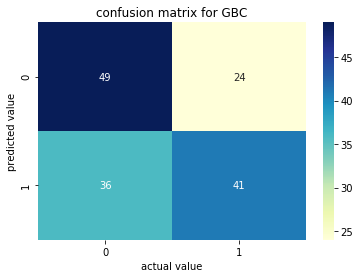

<Figure size 432x288 with 0 Axes>

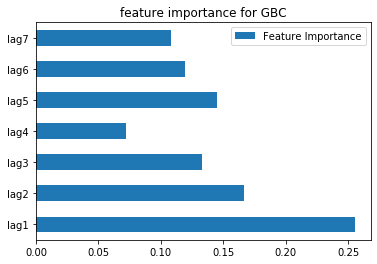

In [11]:
model = gbc
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="YlGnBu",fmt=".0f", annot=True)
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.title("confusion matrix for GBC")
plt.savefig("./plots/GBM_cmatrix")

plt.figure()
pd.DataFrame({'Feature Importance':model.feature_importances_},
            index=x_test.columns).plot(kind='barh')
plt.title("feature importance for GBC")
plt.savefig("./plots/GBM_f_importance")

### Logistic Regression

In [12]:
param_grid = {"solver": ["lbfgs", "liblinear"],
              "fit_intercept": [True, False],
              "C": [0.7, 0.8, 0.9, 1]}
lg = GridSearchCV(LogisticRegression(), param_grid, cv=10)
lg.fit(x_train, y_train)
lg = lg.best_estimator_
print(lg)
print("score on train:", lg.score(x_train, y_train))
print("score on test:", lg.score(x_test, y_test))

LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
score on train: 0.7134670487106017
score on test: 0.7


/Users/clarence/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.67      0.77      0.71        73
           1       0.74      0.64      0.69        77

    accuracy                           0.70       150
   macro avg       0.70      0.70      0.70       150
weighted avg       0.71      0.70      0.70       150



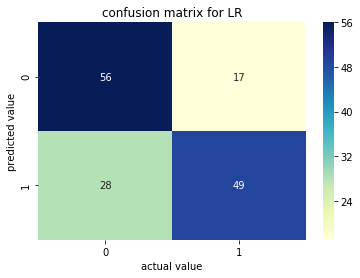

In [13]:
model = lg
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="YlGnBu",fmt=".0f", annot=True)
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.title("confusion matrix for LR")
plt.savefig("./plots/LR_cmatrix")

# plt.figure()
# pd.DataFrame({'Feature Importance':model.feature_importances_},
#             index=x_test.columns).plot(kind='barh')
# plt.title("feature importance for LR")
# plt.savefig("./plots/LR_f_importance")